In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error,mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

Pandas, XGBoost, Sklearn, Matplotlib are used to build, run, and plot results for the XGBoost model

In [2]:
xg_df = pd.read_csv("final_data_2010_2021.csv")

In [3]:
xg_df["DATETIME"] = pd.to_datetime(xg_df['DATETIME'], format='%Y/%m/%d %H:%M')
xg_df = xg_df[xg_df["DATETIME"]>= '2018-04-01']
xg_df["HOUR"] = xg_df["DATETIME"].dt.hour
xg_df =xg_df.drop(columns=["DATETIME","DAYOFWEEK","WEEKDAY"])
xg_df['lag_1'] = xg_df["TOTALDEMAND"].shift(1)
xg_df['lag_2'] = xg_df["TOTALDEMAND"].shift(2)
xg_df['lag_3'] = xg_df["TOTALDEMAND"].shift(3)
print(xg_df.head())

        TOTALDEMAND  TEMPERATURE  HOLIDAY  HOUR  MONTH  SUMMER  AUTUMN  \
144576      6775.90         18.7        1     0      4       0       1   
144577      6598.45         18.5        1     0      4       0       1   
144578      6428.87         18.6        1     1      4       0       1   
144579      6158.19         18.2        1     1      4       0       1   
144580      6012.85         18.1        1     2      4       0       1   

        WINTER  SPRING  PEAK    lag_1    lag_2    lag_3  
144576       0       0     0      NaN      NaN      NaN  
144577       0       0     0  6775.90      NaN      NaN  
144578       0       0     0  6598.45  6775.90      NaN  
144579       0       0     0  6428.87  6598.45  6775.90  
144580       0       0     0  6158.19  6428.87  6598.45  


TOTALDEMAND is the target and the rest of the columns are features

In [4]:
X = xg_df.drop(columns=["TOTALDEMAND"])
Y = xg_df["TOTALDEMAND"]

Drop the target column from the independent variables and create a new Y variable with the target

In [5]:
train_size = int(len(X)*0.8)

X_train, X_test = X[:train_size], X[train_size:]
Y_train, Y_test = Y[:train_size], Y[train_size:]

80% training and 20% testing and the split is done in chronological order

In [6]:
xg_model = xgb.XGBRegressor(objective='reg:squarederror',random_state=24)

parameters = {
    'n_estimators':[100,200,300,500],
    'learning_rate':[0.01,0.05,0.1,0.3],
    'max_depth':[3,5,7,10],
    #'subsample':[0.6,0.8,1],
    #'colsample_bytree': [0.6,0.8,1],
    'gamma':[0,0.1,0.3]
}

Model initialisation and hyperparameter space

In [7]:
tsplit = TimeSeriesSplit(n_splits=5)

random_search = RandomizedSearchCV(estimator=xg_model, param_distributions=parameters, n_iter=50,
                                   scoring='neg_mean_squared_error', cv=tsplit, verbose=1, n_jobs=-1, random_state=42)

TimeSeriesSplit is a function to crossvalidate time series

In [8]:
random_search.fit(X_train,Y_train)

demand_pred = random_search.predict(X_test)

print(random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0.1}


The above are the best parameters for after hyperparameter tuning using random search

In [9]:
comparison_df= pd.DataFrame({'Actual Demand':Y_test,"Predicted":demand_pred,"Difference":Y_test-demand_pred})
print(comparison_df)

        Actual Demand    Predicted  Difference
186125        7040.99  7084.316895  -43.326895
186126        7263.36  7212.971680   50.388320
186127        7353.60  7482.277344 -128.677344
186128        7686.91  7609.273438   77.636562
186129        7995.87  8002.513672   -6.643672
...               ...          ...         ...
196508        7419.77  7435.742676  -15.972676
196509        7417.91  7372.693848   45.216152
196510        7287.32  7314.993164  -27.673164
196511        7172.39  7168.186523    4.203477
196512        7094.51  7023.211426   71.298574

[10388 rows x 3 columns]


A data frame with actual comparison check to see the MegaWatt (MW) difference

In [10]:
rmse = np.sqrt(mean_squared_error(Y_test,demand_pred))
mae = mean_absolute_error(Y_test,demand_pred)

print(f"Root Mean Squared Error: {rmse}")
print(f"Mean Absolute Error: {mae}")

Root Mean Squared Error: 84.3317320917366
Mean Absolute Error: 62.384501043120665


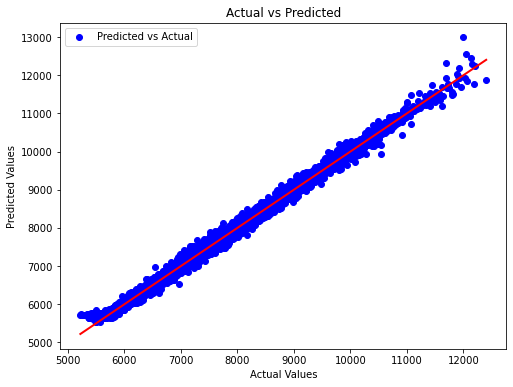

In [11]:
plt.figure(figsize=(8,6))
plt.scatter(Y_test,demand_pred,color='blue',label='Predicted vs Actual')
plt.plot([min(Y_test), max(Y_test)], [min(Y_test), max(Y_test)], color='red', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted')
plt.legend()

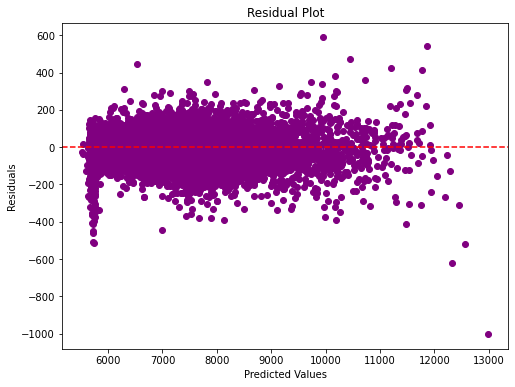

In [12]:
residuals = Y_test - demand_pred

plt.figure(figsize=(8,6))
plt.scatter(demand_pred, residuals, color='purple')
plt.axhline(y=0, color='red', linestyle='--')  
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

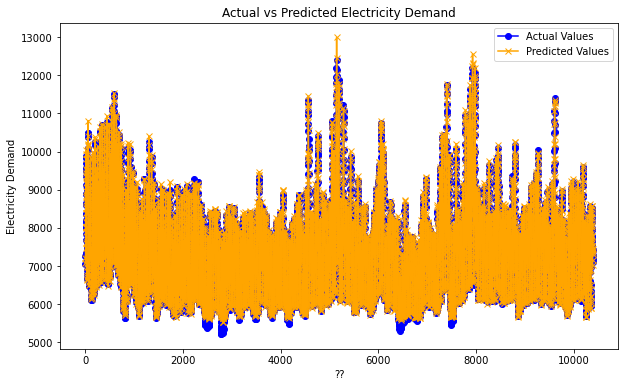

In [13]:
plt.figure(figsize=(10,6))
plt.plot(Y_test.values, label='Actual Values', color='blue', marker='o')
plt.plot(demand_pred, label='Predicted Values', color='orange', marker='x')
plt.xlabel('??')
plt.ylabel('Electricity Demand')
plt.title('Actual vs Predicted Electricity Demand')
plt.legend()